In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('ggplot')
# figure size in inches
rcParams['figure.figsize'] = 8, 4

sns.set(font_scale=1.5)
# pd.set_option('display.max_rows', None)

from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# Load csv files as data frames.
path = '../data/all-data/'
df1 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv(f'{path}Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv(f'{path}Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv(f'{path}Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv(f'{path}Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv(f'{path}Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv(f'{path}Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv(f'{path}Wednesday-workingHours.pcap_ISCX.csv')

#### Common Network Prts

| Port Number | Usage |
|:--- | :--- | 
| File Transfer Protocol (FTP) Data Transfe | 20 |
| File Transfer Protocol (FTP) Command Control  | 21 |
| Secure Shell (SSH) | 22 |
| Telnet - Remote login service, unencrypted text messages  | 23 |
| Simple Mail Transfer Protocol (SMTP) E-mail Routi | 25 |
| Domain Name System (DNS) service  | 53 |
| Hypertext Transfer Protocol (HTTP) used in World Wide Web | 80 |
| Post Office Protocol (POP3) used by e-mail clients to retrieve e-mail from a serv | 110 |
| Network News Transfer Protocol (NNTP) | 119 |
| Network Time Protocol (NT) | 123 |
| Internet Message Access Protocol (IMAP) Management of Digital Mail | 143 |
| Simple Network Management Protocol (SNMP) | 161 |
| Internet Relay Chat (IRC) | 194 |
| HTTP Secure (HTTPS) HTTP over TLS/SSL | 443 |

In [3]:
# Drop low count "Destination Port" from the 4th data frame (Benign activities data frame).
high_count_benign_ports = df4[' Destination Port'].value_counts()[:20].index
df4 = df4[df4[' Destination Port'].isin(high_count_benign_ports)]
df4.reset_index(drop=True, inplace=True)

In [4]:
# Remove etries labled "BENIGN" from all dataframes except the 4th data frame.
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
for i, df in enumerate(dfs):
    if i != 3:
        dfs[i] = dfs[i][dfs[i][' Label'] != 'BENIGN']

# Concatenate all data frames.
final_df = pd.concat(dfs)

# Print shape of the final data frame before updates.
print('Data frame shape before updates...')
print(final_df.shape, end='\n\n')

Data frame shape before updates...
(979537, 79)



In [5]:
# Remove extra spaces from feature names.
cols = final_df.columns.str.strip()
final_df.columns = cols

# Convert labels to lower case and replace column names spaces with "_".
cols = []
for i, col in enumerate(final_df.columns):
    new_col_name = col.lower()
    new_col_name = '_'.join(new_col_name.split())
    cols.append(new_col_name)
final_df.columns = cols

# Add new feature "is_intrusion" and make it's value for each entry 0.
final_df['is_intrusion'] = 0

# Chnage "is_intrusion" values for entries that are not labeled "benign" to 1.
final_df.loc[final_df['label'] != 'BENIGN', 'is_intrusion'] = 1

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979537, 80)


In [6]:
# Drop columns that have the same value for all entries.
for i, col in enumerate(final_df.columns[:-2]):
    if (final_df[col] == final_df[col][0]).all():
        final_df = final_df.drop(columns=[col]) 

# Reset final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979537, 70)


In [7]:
# Print target classes
final_df.label.value_counts()

BENIGN                        421891
DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: label, dtype: int64

In [8]:
# Transform "labele" values to lower case.
final_df.label = final_df.label.str.lower()

# Group similar attacks.
final_df.loc[final_df['label'].str.startswith('dos'), 'label'] = 'dos'
final_df.loc[final_df['label'].str.startswith('web'), 'label'] = 'web_attack'
final_df.loc[final_df['label'].str.endswith('patator'), 'label'] = 'brute_force'

# Drop entires that have Labels with low count (<100).
labeles_to_drop = final_df.label.value_counts()[-2:].index
final_df.drop(final_df.index[final_df['label'].isin(labeles_to_drop)], inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

Data frame shape after updates...
(979490, 70)


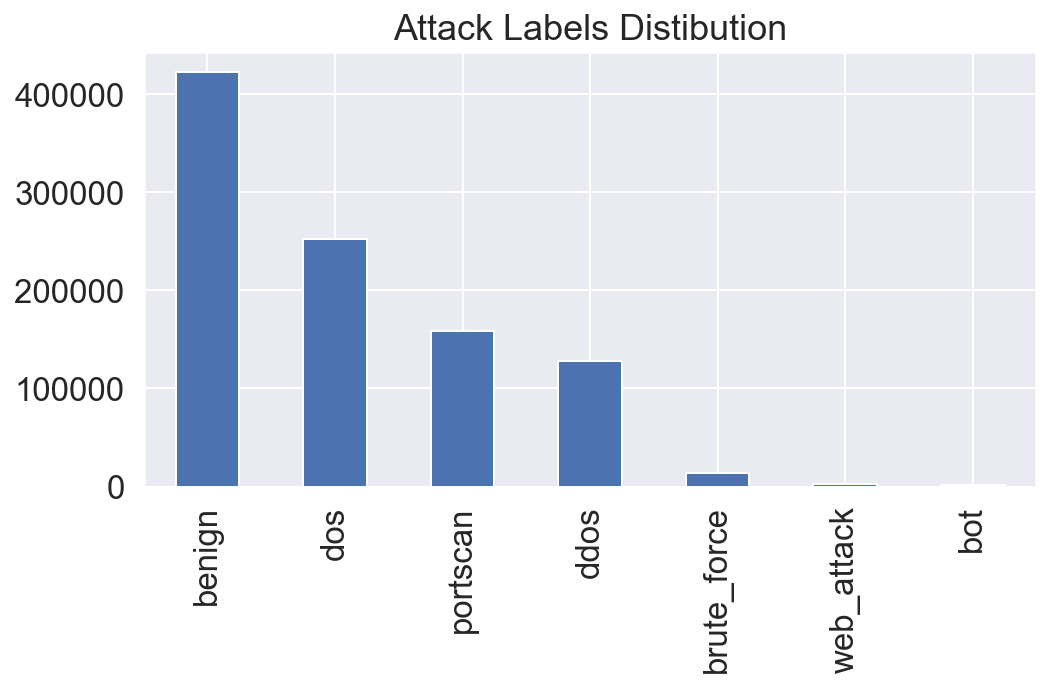

In [9]:
# Plot Attck Label distibution.
final_df.label.value_counts().plot.bar()
plt.title('Attack Labels Distibution')
plt.show()

In [10]:
# Check for Null values.
print('How many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Replace Inf values with NaN.
final_df = final_df.replace([np.inf, -np.inf], np.nan)

# Drop all occurences of NaN.
print('Removing Null values...')
final_df = final_df.dropna()

# Rest final data frame indexes.      
final_df.reset_index(drop=True, inplace=True)

# Double check these are all gone.
print('\nHow many Null values are there?')
print(final_df.isnull().sum().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many Null values are there?
977

Removing Null values...

How many Null values are there?
0

Data frame shape after updates...
(978201, 70)


In [11]:
# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Drop duplicated entries.
print('Droping duplicated entries...', end='\n\n')
final_df.drop_duplicates(inplace=True)

# Rest final data frame indexes.       
final_df.reset_index(drop=True, inplace=True)

# Find duplicated entries.
print('How many duplicated entries are there?')
print(final_df.duplicated().sum(), end='\n\n')

# Print the update shape of the final data frame.
print('Data frame shape after updates...')
print(final_df.shape)

How many duplicated entries are there?
157478

Droping duplicated entries...

How many duplicated entries are there?
0

Data frame shape after updates...
(820723, 70)


In [12]:
# # Drop bot attacks that has low "destination_port" count (==1).
# # Note: these entries have the same values for all feature except for "destination_port".
# low_port_count_bots_indexes = final_df[(final_df['label'] == 'bot') & (final_df['destination_port'] != 8080)].index
# final_df.drop(low_port_count_bots_indexes, axis=0, inplace=True)

# # Rest final data frame indexes.       
# final_df.reset_index(drop=True, inplace=True)

# # Print the update shape of the final data frame.
# print('Data frame shape after updates...')
# print(final_df.shape)

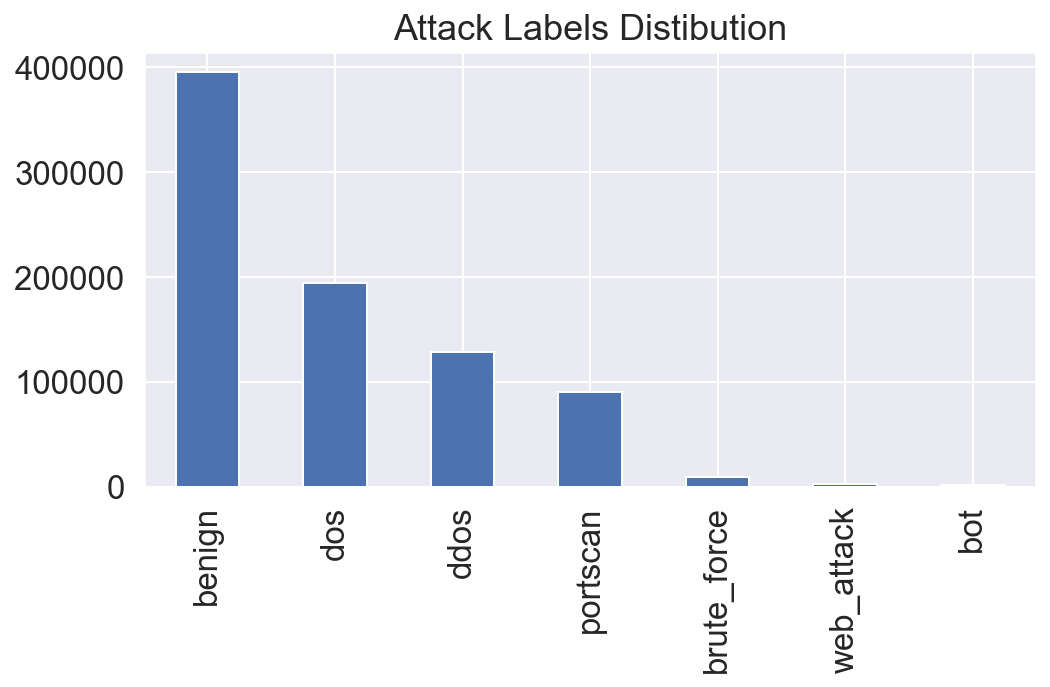

In [13]:
# Plot Attck Label distibution.
final_df.label.value_counts().plot.bar()
plt.title('Attack Labels Distibution')
plt.show()

In [14]:
# Display features statistics.
# final_df.describe().transpose()

In [15]:
# final_df.corr(method='pearson')#.style.background_gradient(cmap="Greens", axis=0)

In [16]:
# fig = px.scatter(final_df, 'total_fwd_packets', 'total_backward_packets', color='label')
# fig.layout.update({'height':700, 'width':900},  title_x=0.5)
# # fig.update_layout(font=dict(size=20))
# fig.show()

In [17]:
# Write the final data frame to a csv file. 
final_df.to_csv(f'{path}intrusion_detection_data.csv', index=False)

In [18]:
df = pd.read_csv(f'{path}intrusion_detection_data.csv')

In [19]:
df.shape

(820723, 70)

In [20]:
df.sample(5)

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label,is_intrusion
68566,80,1508614,3,6,26,11607,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,ddos,1
504267,443,32749,1,1,6,6,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,benign,0
722166,80,85609022,7,6,724,11595,353,0,103.428571,170.510857,...,11036.0,0.0,11036,11036,85200000.0,0.0,85200000,85200000,dos,1
726472,80,100333875,7,7,326,11595,326,0,46.571429,123.216418,...,4.0,0.0,4,4,99200000.0,0.0,99200000,99200000,dos,1
559869,53,280,2,2,72,146,36,36,36.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,benign,0


In [21]:
for col in df.columns:
    print(df[col].value_counts().to_frame(), end='\n\n')
    print(100*'-')


       destination_port
80               372071
53               202238
443              132328
21                 6848
123                4964
...                 ...
51666                 1
53518                 1
52349                 1
3632                  1
2757                  1

[1690 rows x 1 columns]

----------------------------------------------------------------------------------------------------
          flow_duration
49                 2135
48                 2093
43                 2048
44                 2042
42                 1925
...                 ...
31418682              1
181448                1
283689                1
31290290              1
11512230              1

[513061 rows x 1 columns]

----------------------------------------------------------------------------------------------------
        total_fwd_packets
2                  171443
1                  162950
3                   95306
8                   55956
5                   55928
...         

#### Feature Selection (Chi-squared test)

In [23]:
neg_col = []
for col in df.columns[:-2]:
    if (df[col] < 0).any():
        neg_col.append(col)
neg_col

['flow_duration',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_min',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_header_length.1',
 'init_win_bytes_forward',
 'init_win_bytes_backward',
 'min_seg_size_forward']

In [27]:
df.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count'

In [26]:
df.shape

(820723, 70)

In [28]:
X = df.drop(columns=['label', 'is_intrusion'] + neg_col)
y = df['label']

In [30]:
chi2_sortedlist = chi2(X, y)

In [33]:
chi2_sortedlist = dict(zip(X.columns, chi2_sortedlist[0]))
chi2_sortedlist

{'destination_port': 5536055546.278998,
 'total_fwd_packets': 1936977.4352065795,
 'total_backward_packets': 3013457.3956632563,
 'total_length_of_fwd_packets': 170384644.52406728,
 'total_length_of_bwd_packets': 4528821081.21806,
 'fwd_packet_length_max': 55753380.8358379,
 'fwd_packet_length_min': 8604843.870064097,
 'fwd_packet_length_mean': 11303426.26845508,
 'fwd_packet_length_std': 23410756.552231643,
 'bwd_packet_length_max': 1771243668.662361,
 'bwd_packet_length_min': 25125525.25303659,
 'bwd_packet_length_mean': 525445584.6293213,
 'bwd_packet_length_std': 816772930.4538387,
 'flow_iat_std': 7625630609038.417,
 'fwd_iat_total': 21191931035520.285,
 'fwd_iat_mean': 4048298631211.2075,
 'fwd_iat_std': 12836010517989.367,
 'fwd_iat_max': 28529024708819.668,
 'bwd_iat_total': 5137766080783.868,
 'bwd_iat_mean': 1149409370462.0215,
 'bwd_iat_std': 4309534702623.451,
 'bwd_iat_max': 8541056671773.673,
 'bwd_iat_min': 370786540872.24963,
 'fwd_psh_flags': 25698.64195867508,
 'fwd_p

In [34]:
chi2_sortedlist = dict(sorted(chi2_sortedlist.items(), key=lambda item: item[1]))
chi2_sortedlist

{'rst_flag_count': 77.58915927691385,
 'ece_flag_count': 77.58915927691385,
 'urg_flag_count': 23030.085842077693,
 'fwd_psh_flags': 25698.64195867508,
 'syn_flag_count': 25698.64195867508,
 'down/up_ratio': 26917.527465998934,
 'psh_flag_count': 123590.63828730304,
 'ack_flag_count': 142525.58961525894,
 'fin_flag_count': 163081.74736977177,
 'total_fwd_packets': 1936977.4352065795,
 'subflow_fwd_packets': 1936977.4352065795,
 'act_data_pkt_fwd': 2312148.267363821,
 'total_backward_packets': 3013457.3956632563,
 'subflow_bwd_packets': 3013457.3956632563,
 'fwd_packet_length_min': 8604843.870064097,
 'min_packet_length': 8834603.000631075,
 'fwd_packet_length_mean': 11303426.26845508,
 'avg_fwd_segment_size': 11303426.268455083,
 'fwd_packet_length_std': 23410756.552231643,
 'bwd_packet_length_min': 25125525.25303659,
 'fwd_packet_length_max': 55753380.8358379,
 'total_length_of_fwd_packets': 170384644.52406728,
 'subflow_fwd_bytes': 170384644.52406728,
 'packet_length_mean': 224880611

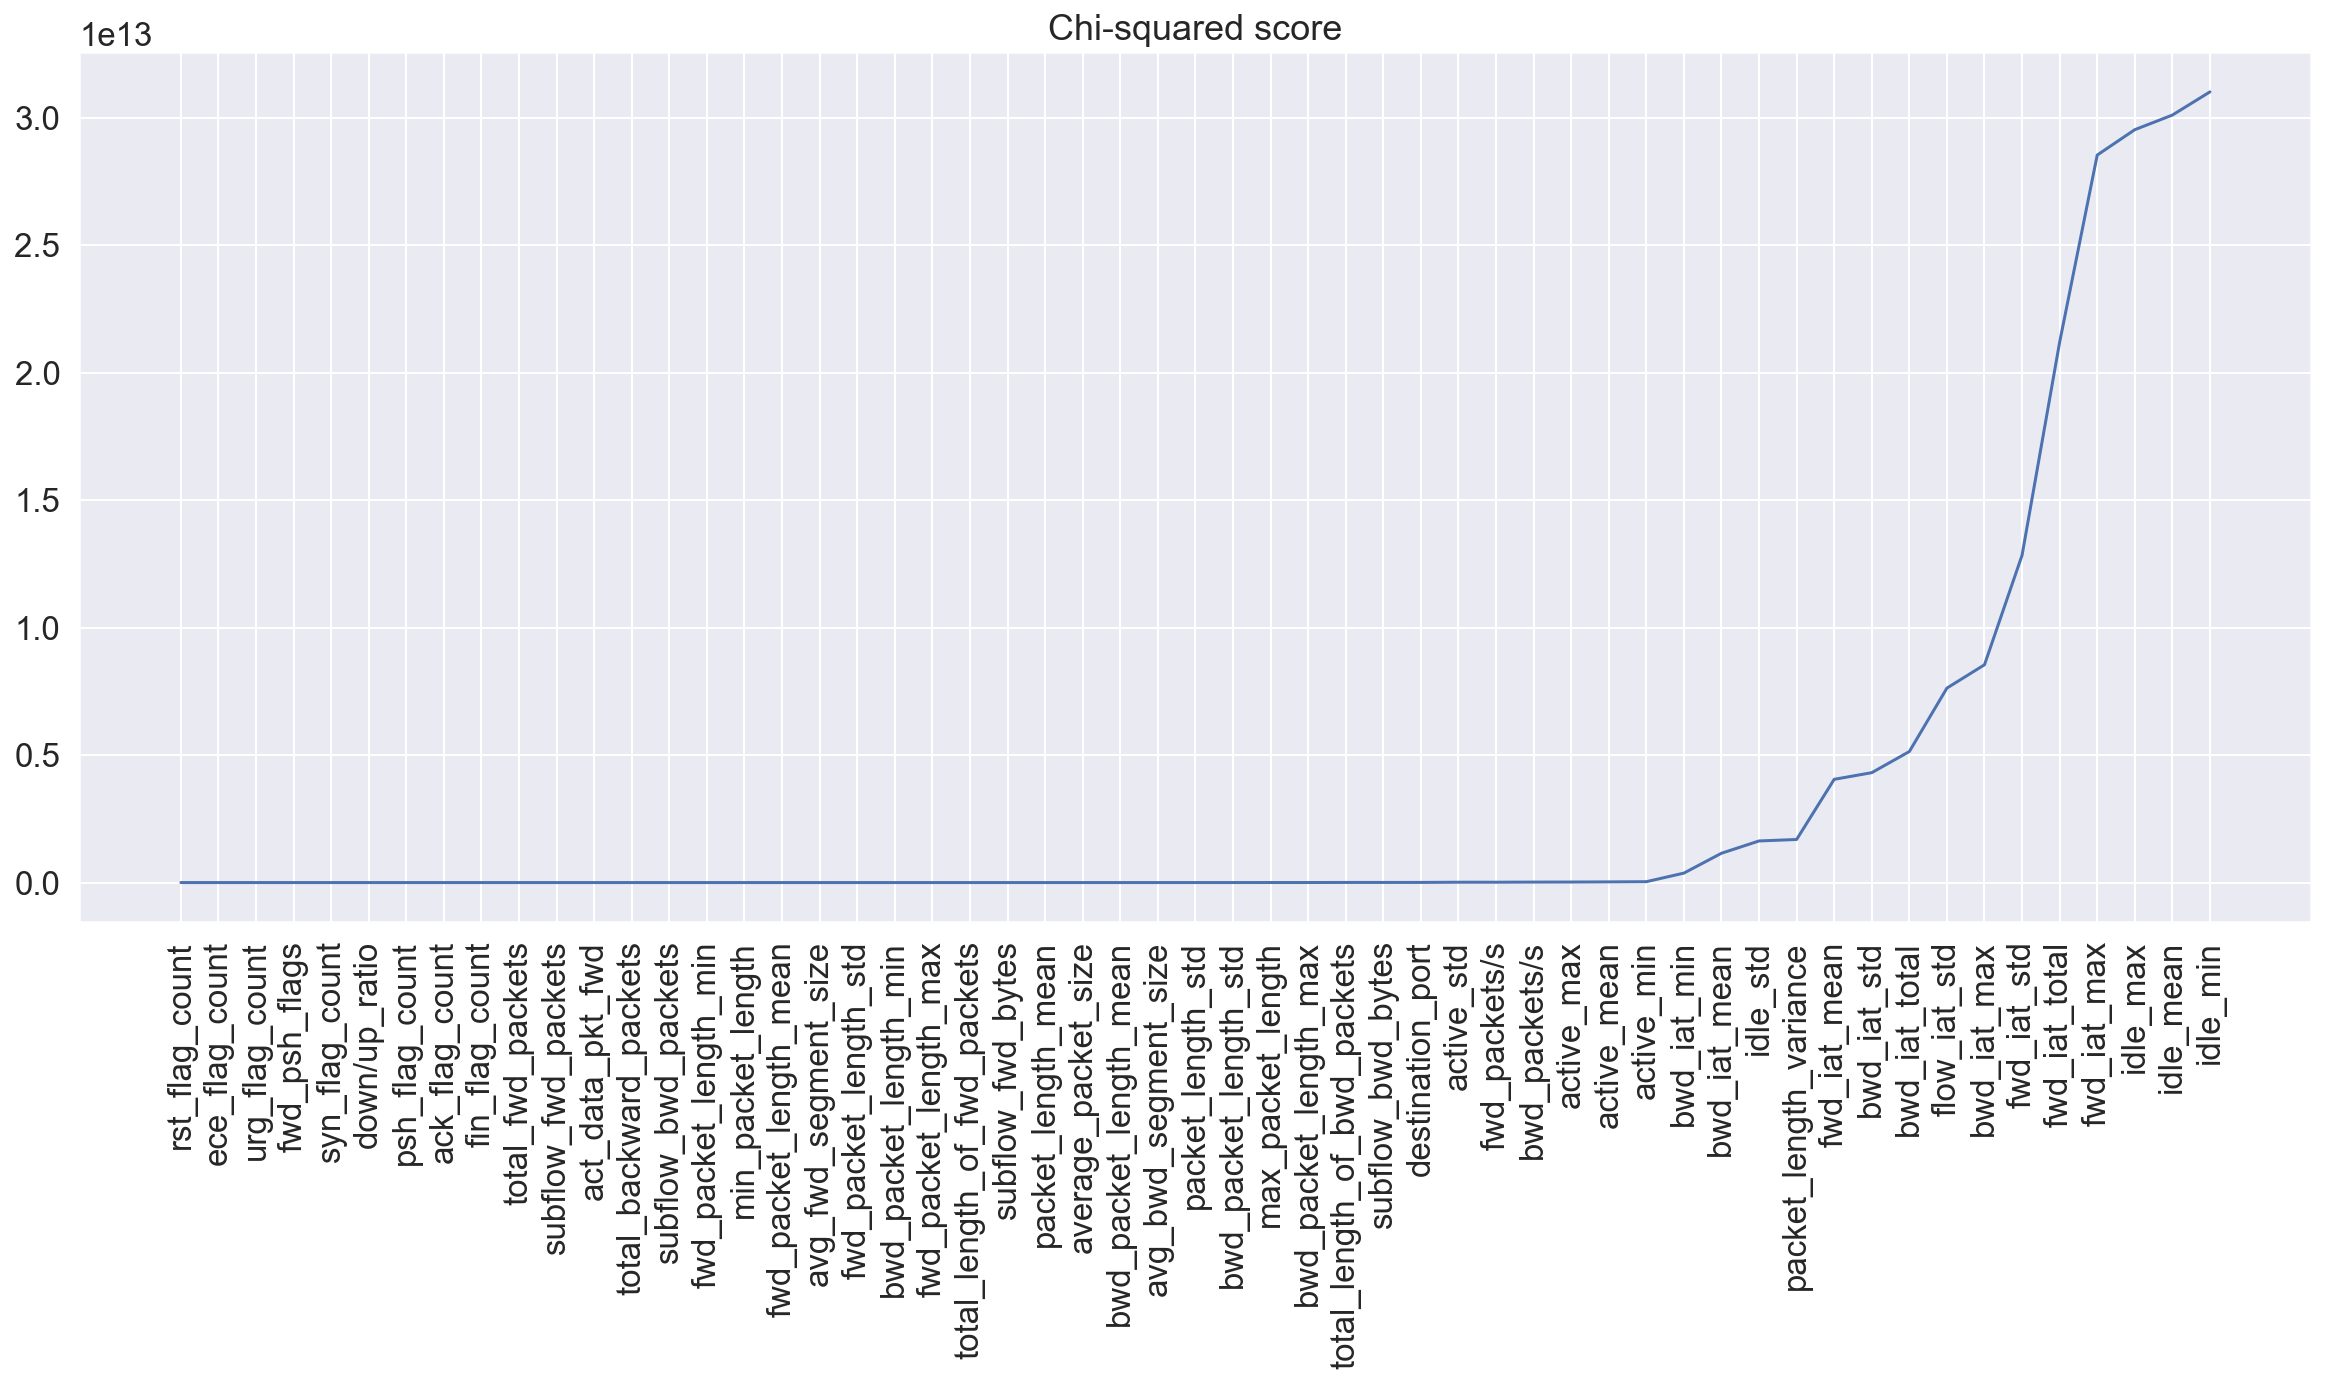

In [35]:
plt.figure(figsize=(20, 8))
plt.plot([k for k in chi2_sortedlist], [chi2_sortedlist[k] for k in chi2_sortedlist])
plt.xticks(rotation='vertical')
plt.title('Chi-squared score')
plt.show();

In [ ]:
X = df.drop(columns=['label', 'is_intrusion'] + neg_col)
y = df['label']
selected_features = SelectKBest(chi2, k=40).fit_transform(X, y)